[*********************100%%**********************]  1 of 1 completed
<ipython-input-1-9e7a13f111c5>:125: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  states = torch.FloatTensor(states)


Episode: 1, Total Reward: 96495.88098716736, Epsilon: 1.00
Episode: 2, Total Reward: 134882.1490998268, Epsilon: 0.99
Episode: 3, Total Reward: 44388.85471582413, Epsilon: 0.99
Episode: 4, Total Reward: 52748.67911148071, Epsilon: 0.99
Episode: 5, Total Reward: 112282.7611951828, Epsilon: 0.98
Episode: 6, Total Reward: 105221.73371171951, Epsilon: 0.98
Episode: 7, Total Reward: 151552.82961273193, Epsilon: 0.97
Episode: 8, Total Reward: -212906.54526090622, Epsilon: 0.97
Episode: 9, Total Reward: 202791.2607073784, Epsilon: 0.96
Episode: 10, Total Reward: 111250.36167478561, Epsilon: 0.96
Episode: 11, Total Reward: 68048.60469532013, Epsilon: 0.95
Episode: 12, Total Reward: -100843.15411281586, Epsilon: 0.95
Episode: 13, Total Reward: 23094.248919010162, Epsilon: 0.94
Episode: 14, Total Reward: -237027.62001752853, Epsilon: 0.94
Episode: 15, Total Reward: 73635.35563755035, Epsilon: 0.93
Episode: 16, Total Reward: 82718.18290710449, Epsilon: 0.93
Episode: 17, Total Reward: 114934.65088

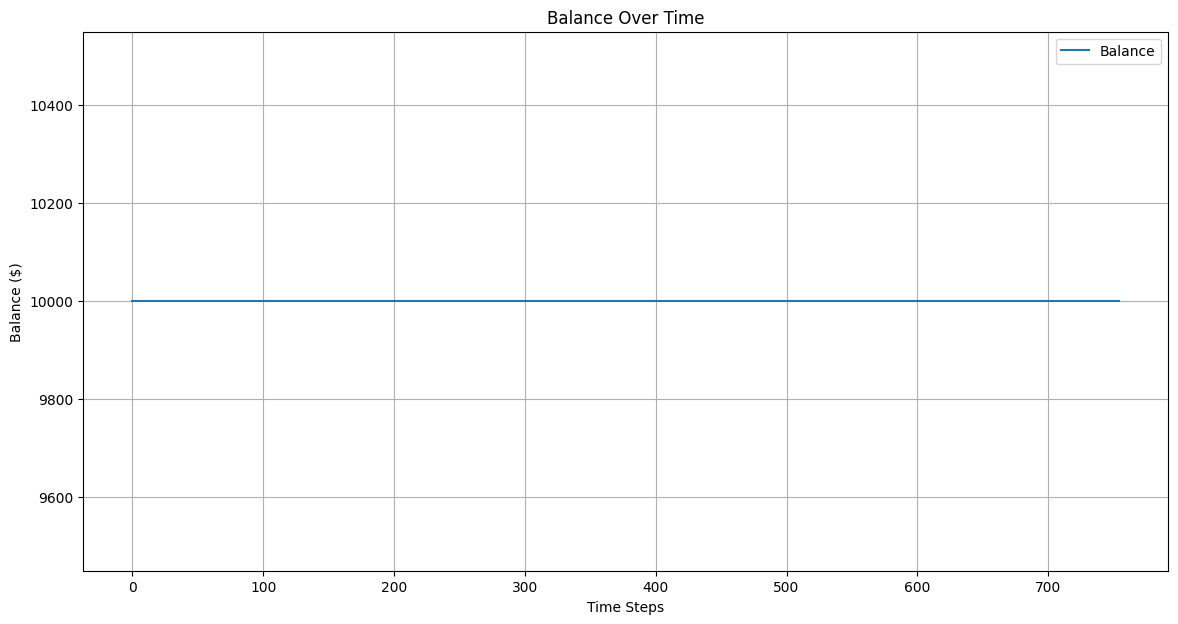

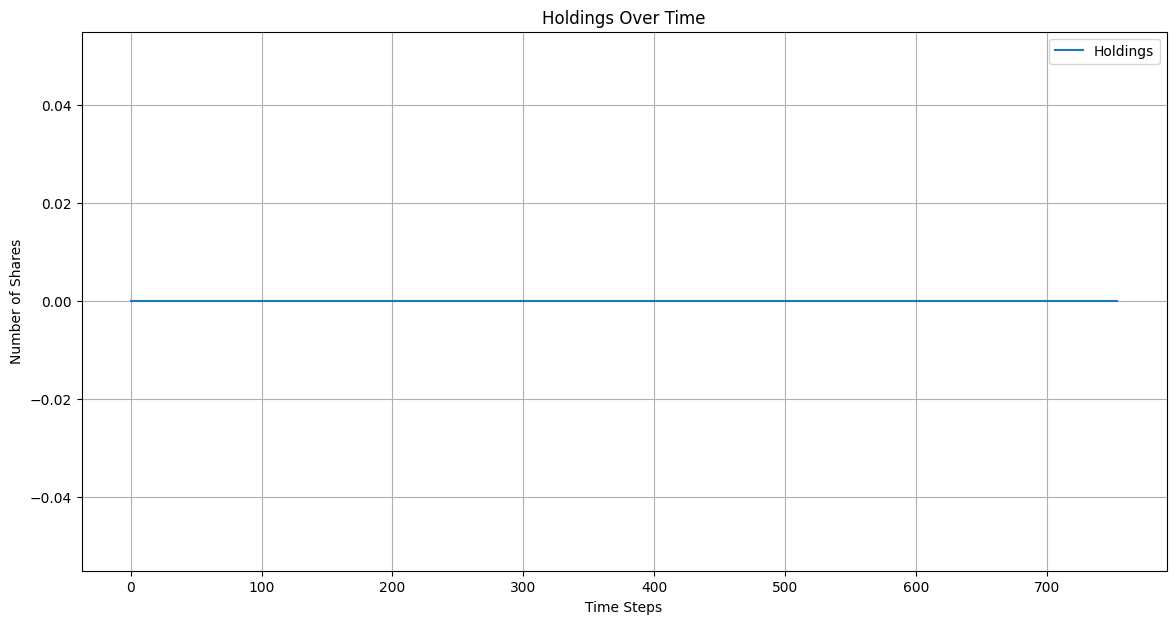

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Download NVIDIA stock data from Yahoo Finance
nvidia = yf.download('NVDA', start='2020-01-01', end='2023-01-01')

# Define a custom gym environment for stock trading
class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.action_space = spaces.Discrete(3)  # 0: Sell, 1: Hold, 2: Buy
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(5,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = 10000  # Initial balance
        self.holdings = 0  # Initial holdings
        self.history = []
        return self._next_observation()

    def _next_observation(self):
        obs = np.array([
            self.df['Open'].values[self.current_step],
            self.df['High'].values[self.current_step],
            self.df['Low'].values[self.current_step],
            self.df['Close'].values[self.current_step],
            self.balance
        ])
        return obs

    def step(self, action):
        self.current_price = self.df['Close'].values[self.current_step]

        if action == 0:  # Sell
            self.balance += self.current_price * self.holdings
            self.holdings = 0
        elif action == 1:  # Hold
            pass
        elif action == 2:  # Buy
            self.holdings += self.balance // self.current_price
            self.balance -= self.current_price * self.holdings

        self.history.append({'balance': self.balance, 'holdings': self.holdings, 'price': self.current_price})

        self.current_step += 1

        reward = self.balance + self.holdings * self.current_price  # Custom reward function (e.g., total portfolio value)

        done = self.current_step >= len(self.df) - 1

        obs = self._next_observation()

        return obs, reward, done, {}

# Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the environment
env = StockTradingEnv(nvidia)

# Hyperparameters
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
batch_size = 32
memory_size = 10000
num_episodes = 100

# Initialize the Q-Network and optimizer
q_network = QNetwork(state_size, action_size)
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Replay memory
memory = deque(maxlen=memory_size)

# Function to select action
def select_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = q_network(state)
        return np.argmax(q_values.numpy())

# Function to store experience in replay memory
def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# Function to train the Q-Network
def train_q_network():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_network(next_states).max(1)[0]
    target_q_values = rewards + (1 - dones) * gamma * next_q_values

    loss = criterion(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training the DQN
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    while True:
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        store_experience(state, action, reward, next_state, done)
        train_q_network()

        state = next_state
        total_reward += reward

        if done:
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Evaluate the trained model
state = env.reset()
total_reward = 0

while True:
    action = select_action(state, epsilon=0.0)
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    state = next_state
    if done:
        break

print(f"Total Test Reward: {total_reward}")

# Plotting results
history_df = pd.DataFrame(env.history)

plt.figure(figsize=(14, 7))
plt.plot(history_df['balance'], label='Balance')
plt.title('Balance Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Balance ($)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(history_df['holdings'], label='Holdings')
plt.title('Holdings Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Number of Shares')
plt.legend()
plt.grid(True)
plt.show()
